#Image processing algorithms hackathon 4/27/2016

In [1]:
%matplotlib inline

import numpy as np
import skimage.io

import matplotlib.pyplot as plt

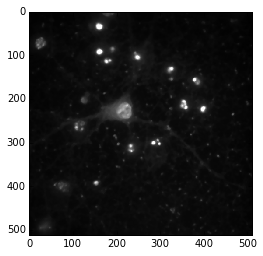

In [2]:
# read image
img = skimage.io.imread('Rat_Hippocampal_Neuron.png')
imgplt = plt.imshow(img, "gray", interpolation="nearest")

In [3]:
# obtain histogram
(data, bin) = np.histogram(img, bins=255)

# normalize
norm_histo = data.astype(np.float)/img.size

In [4]:
P1 = norm_histo.cumsum()
P2 = 1 - P1

first_bin  = next((i for (i, x) in zip(bin, P1) if x), None).astype(int)
last_bin  = next((i for (i, x) in zip(reversed(bin), reversed(P2)) if x), None).astype(int)

In [5]:
max_ent = np.finfo(float).eps

for it in range(first_bin, last_bin+1):
    x = norm_histo[:it+1]
    x = x[x!=0]/P1[it]
    #ent_back = (-norm_histo[data!=0]/P1[it])*np.log(-norm_histo[data!=0]/P1[it])
    ent_back = np.sum((-x)*np.log(x))
    
    x = norm_histo[it+1:]
    x = x[x != 0]/P2[it]
    #ent_back = (-norm_histo[data!=0]/P1[it])*np.log(-norm_histo[data!=0]/P1[it])
    ent_obj = np.sum((-x)*np.log(x))
    
    tot_ent = ent_back + ent_obj
    if (tot_ent > max_ent):
        max_ent = tot_ent
        threshold = it
    
print threshold, max_ent

67 7.86050513261


#Code refactoring 4/28/2016

__Define function here__

In [6]:
def max_entropy(data):
    """
    Implements Kapur-Sahoo-Wong (Maximum Entropy) thresholding method
    Kapur J.N., Sahoo P.K., and Wong A.K.C. (1985) "A New Method for Gray-Level Picture Thresholding Using the Entropy
    of the Histogram", Graphical Models and Image Processing, 29(3): 273-285
    M. Emre Celebi
    06.15.2007
    Ported to ImageJ plugin by G.Landini from E Celebi's fourier_0.8 routines

    2016-04-28: Adapted for Python 2.7 by Robert Metchev from Java source of MaxEntropy() in the Autothresholder plugin
    http://rsb.info.nih.gov/ij/plugins/download/AutoThresholder.java

    :param data: Sequence representing the histogram of the image
    :return threshold: Resulting maximum entropy threshold
    """

    # calculate CDF (cumulative density function)
    cdf = data.astype(np.float).cumsum()

    # find histogram's nonzero area
    valid_idx = np.nonzero(data)[0]
    first_bin = valid_idx[0]
    last_bin = valid_idx[-1]

    # initialize search for maximum
    max_ent, threshold = 0, 0

    for it in range(first_bin, last_bin + 1):
        # Background (dark)
        hist_range = data[:it + 1]
        hist_range = hist_range[hist_range != 0] / cdf[it]  # normalize within selected range & remove all 0 elements
        tot_ent = -np.sum(hist_range * np.log(hist_range))  # background entropy

        # Foreground/Object (bright)
        hist_range = data[it + 1:]
        # normalize within selected range & remove all 0 elements
        hist_range = hist_range[hist_range != 0] / (cdf[last_bin] - cdf[it])
        tot_ent -= np.sum(hist_range * np.log(hist_range))  # accumulate object entropy

        # find max
        if tot_ent > max_ent:
            max_ent, threshold = tot_ent, it

    return threshold

__Testing__

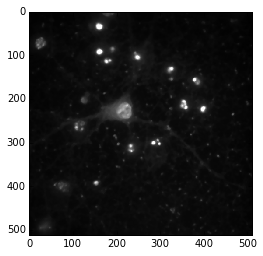

In [7]:
# read image
img = skimage.io.imread('Rat_Hippocampal_Neuron.png')
imgplt = plt.imshow(img, "gray", interpolation="nearest")

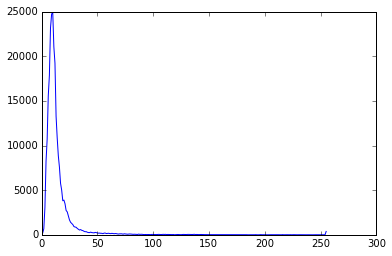

In [8]:
# obtain histogram
hist = np.histogram(img, bins=256, range=(0, 256))[0]
imgplt = plt.plot(range(0,256), hist)

__Calculate threshold and show resulting segmentation__

Threshold= 67


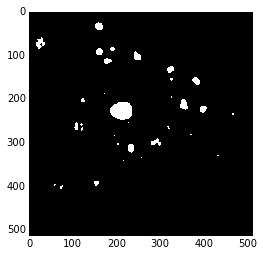

In [9]:
# run max entropy function on the historgram
threshold = max_entropy(hist)
print "Threshold=", threshold

# illustrate result
segmentation = np.zeros_like(img)
segmentation[img > threshold] = 1

imgplt = plt.imshow(segmentation, "gray", interpolation="nearest")